In [ ]:
%pylab inline
import IPython.core.debugger as ipdb
import numpy as np
import torch
import os
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import autograd
# from torch.autograd import Variable
import nibabel as nib
from torch.utils.data.dataset import Dataset
from torch.utils.data import dataloader
from nilearn import plotting
from ADNI_dataset import *
from BRATS_dataset import *
from ATLAS_dataset import *
from Model_alphaWGAN import *

# Configuration

In [ ]:
BATCH_SIZE=4
gpu = True
workers = 4

LAMBDA= 10
_eps = 1e-15
Use_BRATS=False
Use_ATLAS = False

#setting latent variable sizes
latent_dim = 1000

In [ ]:
trainset = ADNIdataset(augmentation=True)
train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
                                          shuffle=True,num_workers=workers)
# if Use_BRATS:
#     #'flair' or 't2' or 't1ce'
#     trainset = BRATSdataset(imgtype='flair')
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size = BATCH_SIZE, shuffle=True,
#                                                num_workers=workers)
# if Use_ATLAS:
#     trainset = ATLASdataset(augmentation=True)
#     train_loader = torch.utils.data.DataLoader(trainset,batch_size=BATCH_SIZE,
#                                           shuffle=True,num_workers=workers)

In [ ]:
def inf_train_gen(data_loader):
    while True:
        for _,images in enumerate(data_loader):
            yield images

In [ ]:
G = Generator(noise = latent_dim)
CD = Code_Discriminator(code_size = latent_dim ,num_units = 4096)
D = Discriminator(is_dis=True)
E = Discriminator(out_class = latent_dim,is_dis=False)

G.cuda()
D.cuda()
CD.cuda()
E.cuda()

In [ ]:
g_optimizer = optim.Adam(G.parameters(), lr=0.0002)
d_optimizer = optim.Adam(D.parameters(), lr=0.0002)
e_optimizer = optim.Adam(E.parameters(), lr = 0.0002)
cd_optimizer = optim.Adam(CD.parameters(), lr = 0.0002)

In [ ]:
def calc_gradient_penalty(model, x, x_gen, w=10):
    """WGAN-GP gradient penalty"""
    assert x.size()==x_gen.size(), "real and sampled sizes do not match"
    alpha_size = tuple((len(x), *(1,)*(x.dim()-1)))
    alpha_t = torch.cuda.FloatTensor if x.is_cuda else torch.Tensor
    alpha = alpha_t(*alpha_size).uniform_()
    #x_hat = x.data*alpha + x_gen.data*(1-alpha)
    x_hat = x*alpha + x_gen*(1-alpha)
    # x_hat = Variable(x_hat, requires_grad=True)
    x_hat.requires_grad = True

    def eps_norm(x):
        x = x.view(len(x), -1)
        return (x*x+_eps).sum(-1).sqrt()
    def bi_penalty(x):
        return (x-1)**2

    grad_xhat = torch.autograd.grad(model(x_hat).sum(), x_hat, create_graph=True, only_inputs=True)[0]

    penalty = w*bi_penalty(eps_norm(grad_xhat)).mean()
    return penalty

# Training

In [ ]:
torch.autograd.set_detect_anomaly(True)
#remove Variable usage
real_y = torch.ones((BATCH_SIZE, 1)).cuda()#async=True))
fake_y = torch.zeros((BATCH_SIZE, 1)).cuda()#async=True))

criterion_bce = nn.BCELoss()
criterion_l1 = nn.L1Loss()
criterion_mse = nn.MSELoss()

In [ ]:

# load the highest savepoints of all models
iteration = 0
checkpoint_pth = './checkpoint/'
if os.path.exists(checkpoint_pth):
    files = set(os.listdir(checkpoint_pth))
    highest_pth = 0 
    for s in files:
        curr_num = int(s.split('iter')[1].split('.')[0])
        highest_pth = max(highest_pth, curr_num)

    if files:
        D.load_state_dict(torch.load(f'./checkpoint/D_iter{highest_pth}.pth'))
        CD.load_state_dict(torch.load(f'./checkpoint/CD_iter{highest_pth}.pth'))
        E.load_state_dict(torch.load(f'./checkpoint/E_iter{highest_pth}.pth'))
        G.load_state_dict(torch.load(f'./checkpoint/G_iter{highest_pth}.pth'))
        iteration = highest_pth
else:
    os.mkdir(checkpoint_pth)


[260/12500]
        D: -51.0   
        En_Ge: -2.18e+02
        Code: 4.72    


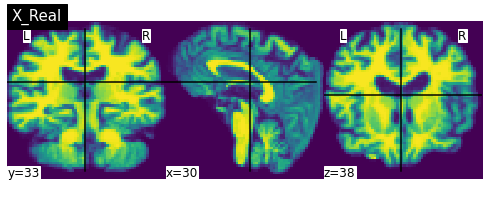

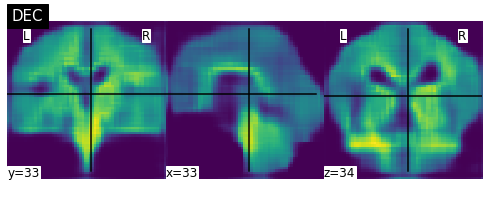

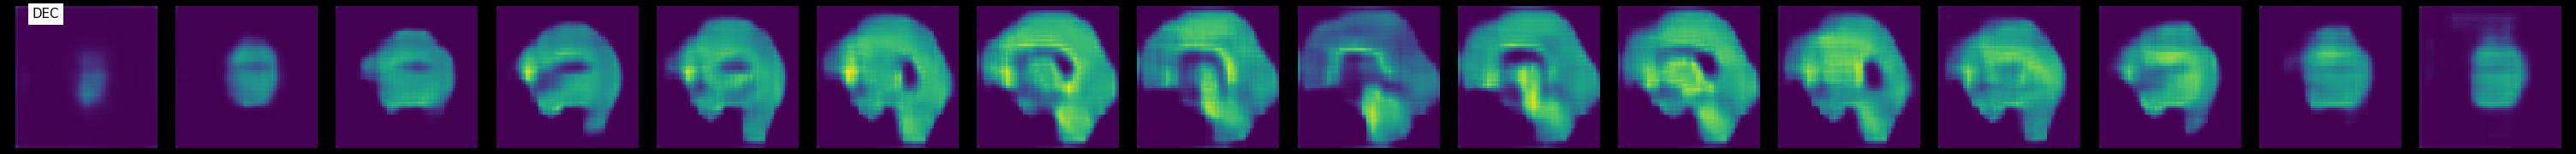

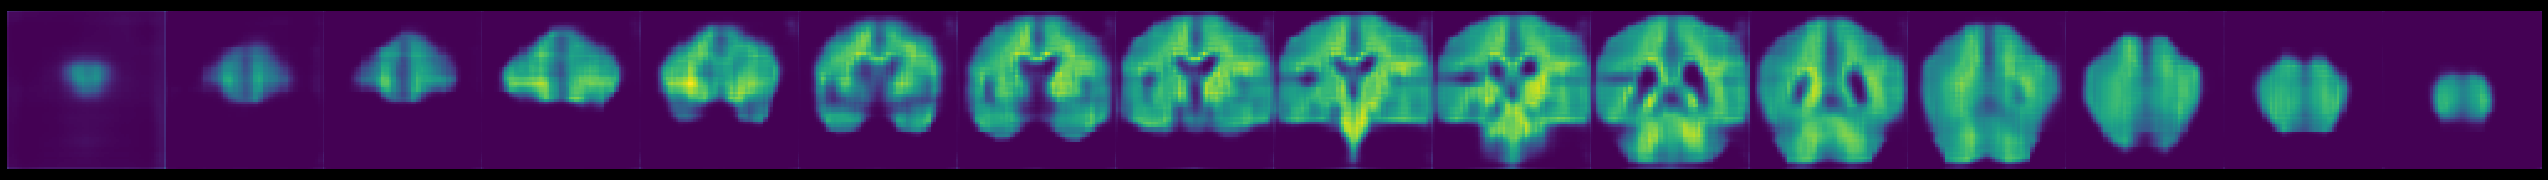

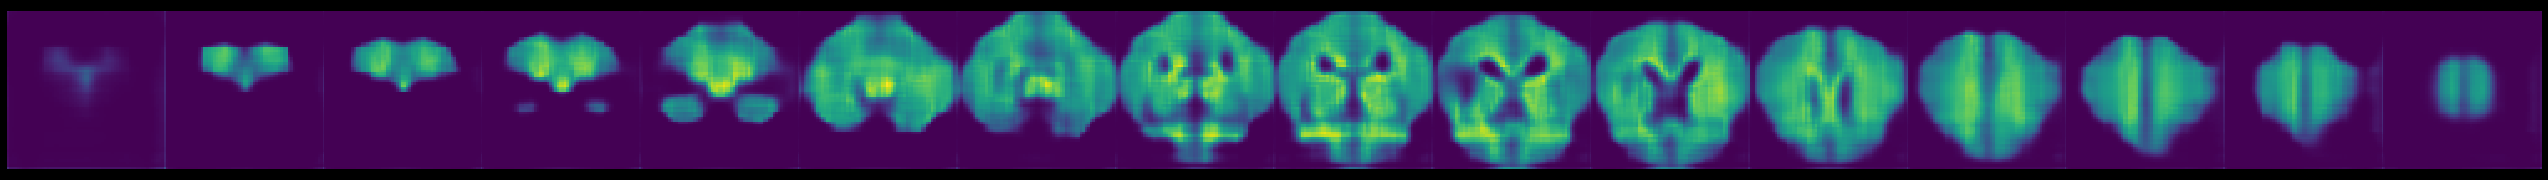

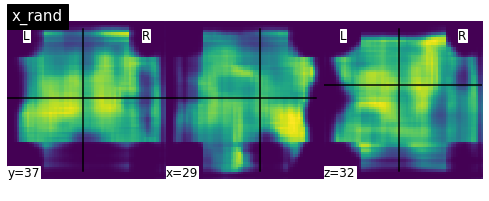

KeyboardInterrupt: 

In [20]:
g_iter = 1
d_iter = 1
cd_iter =1
TOTAL_ITER = 12500
gen_load = inf_train_gen(train_loader)
arr = range(0, 64, 4)


while iteration < TOTAL_ITER:
    for p in D.parameters():  
        p.requires_grad = False
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = True
    for p in G.parameters():  
        p.requires_grad = True

    ###############################################
    # Train Encoder - Generator 
    ###############################################
    for iters in range(g_iter):
        G.zero_grad()
        E.zero_grad()
        real_images = gen_load.__next__()
        _batch_size = real_images.size(0)
        #remove Volatile Variable Usage
        real_images = real_images.cuda()#async=True)
        z_rand = torch.randn((_batch_size,latent_dim)).cuda()
        z_hat = E(real_images).view(_batch_size,-1)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        c_loss = -CD(z_hat).mean()
        

        d_real_loss = D(x_hat).mean()
        d_fake_loss = D(x_rand).mean()
        d_loss = -d_fake_loss-d_real_loss
        l1_loss =10* criterion_l1(x_hat,real_images)
        loss1 = l1_loss + c_loss + d_loss

        if iters<g_iter-1:
            loss1.backward()
        else:
            loss1.backward(retain_graph=True)
        ## assign a copy of c_loss, remove it from the computational graph
        c_loss = c_loss.clone().detach().requires_grad_(True)
        e_optimizer.step() ## contains in-place operation to c_loss, leading to in-place op to loss3
        g_optimizer.step()
        g_optimizer.step()

    ###############################################
    # Train D
    ###############################################
    for p in D.parameters():  
        p.requires_grad = True
    for p in CD.parameters():  
        p.requires_grad = False
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False

    for iters in range(d_iter):
        d_optimizer.zero_grad()
        real_images = gen_load.__next__()
        _batch_size = real_images.size(0)
        #remove Volatile Variable
        z_rand = torch.randn((_batch_size,latent_dim)).cuda()
        real_images = real_images.cuda()#async=True)
        z_hat = E(real_images).view(_batch_size,-1)
        x_hat = G(z_hat)
        x_rand = G(z_rand)
        x_loss2 = -2*D(real_images).mean()+D(x_hat).mean()+D(x_rand).mean()
#         gradient_penalty_r = calc_gradient_penalty(D,real_images.data, x_rand.data)
#         gradient_penalty_h = calc_gradient_penalty(D,real_images.data, x_hat.data)
        gradient_penalty_r = calc_gradient_penalty(D,real_images, x_rand)
        gradient_penalty_h = calc_gradient_penalty(D,real_images, x_hat)

        loss2 = x_loss2+gradient_penalty_r+gradient_penalty_h
        loss2.backward(retain_graph=True)
        d_optimizer.step()

    ###############################################
    # Train CD
    ###############################################
    for p in D.parameters():  
        p.requires_grad = False
    for p in CD.parameters():  
        p.requires_grad = True
    for p in E.parameters():  
        p.requires_grad = False
    for p in G.parameters():  
        p.requires_grad = False
        
    for iters in range(cd_iter):
        cd_optimizer.zero_grad()
        #remove volatile Variable usage
        z_rand = torch.randn((_batch_size,latent_dim)).cuda()
        z_rand.requires_grad = False
#       gradient_penalty_cd = calc_gradient_penalty(CD,z_hat.data, z_rand.data)
        gradient_penalty_cd = calc_gradient_penalty(CD,z_hat, z_rand)
        loss3 = -CD(z_rand).mean() - c_loss + gradient_penalty_cd
        loss3.backward(retain_graph=True)
        cd_optimizer.step()

    ###############################################
    # Visualization
    ###############################################

    if iteration % 10 == 0:
        lossStr = '[{}/{}]'.format(iteration,TOTAL_ITER) + '\n\
        D: {:<8.3}'.format(loss2.item()) + '\n\
        En_Ge: {:<8.3}'.format(loss1.item()) + '\n\
        Code: {:<8.3}'.format(loss3.item()) 
        print(lossStr)
#         feat = np.squeeze((0.5*real_images[0]+0.5).data.cpu().numpy())
        feat = np.squeeze((0.5*real_images[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="X_Real")
        plotting.show()

#         feat = np.squeeze((0.5*x_hat[0]+0.5).data.cpu().numpy())
        feat = np.squeeze((0.5*x_hat[0]+0.5).cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="DEC")
        plotting.show()
        plotting.plot_img(feat,title="DEC", cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
        plotting.plot_img(feat,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='y')
        plotting.plot_img(feat,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='z')

        feat = np.squeeze((0.5*x_rand[0]+0.5).data.cpu().numpy())
        feat = nib.Nifti1Image(feat,affine = np.eye(4))
        plotting.plot_img(feat,title="x_rand")
        plotting.show()
        plotting.plot_img(feat,title="x_rand", cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='x')
        plotting.plot_img(feat,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='y')
        plotting.plot_img(feat,cut_coords=arr,draw_cross=False,annotate=False,black_bg=True,display_mode='z')
        plotting.show()

    ###############################################
    # Model Save
    ###############################################
    if (iteration+1)%100 ==0: 
        torch.save(G.state_dict(),'./checkpoint/G_iter'+str(iteration+1)+'.pth')
        torch.save(D.state_dict(),'./checkpoint/D_iter'+str(iteration+1)+'.pth')
        torch.save(E.state_dict(),'./checkpoint/E_iter'+str(iteration+1)+'.pth')
        torch.save(CD.state_dict(),'./checkpoint/CD_iter'+str(iteration+1)+'.pth')

    iteration += 1
    

In [ ]:
%debug